# Exercise 5

The followting is to rebuild and extend backtest of the portfolios with minor modifications (code copied from previous exercises). And other analysis are in the excel file.

### Discretionary strategy:
Implicit hedging SPY and Size factor - Long Citigroups Inc. and Pfizer Inc.; Short HSBC and Merck & Co.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sympy import *
import warnings
warnings.filterwarnings("ignore")

ret_discret = pd.read_excel("./ex5data.xlsx", sheet_name = "Discretionary",index_col = 0)
ret_discret.head()

,C,PFE,SPY,HSBC,MRK,SIZE
Date,,,,,,
2020-09-22,-0.014676,0.006365,0.030618,-0.015680,-0.002288,0.007216
2020-09-23,-0.033830,-0.006920,-0.072321,0.003808,-0.003745,-0.027414
2020-09-24,0.008091,-0.006689,0.007388,-0.001630,0.006273,0.001433
2020-09-25,-0.004038,0.008077,0.047237,-0.015343,-0.002649,0.015626
2020-09-28,0.030930,0.009387,0.049125,0.097266,-0.002052,0.017199


In [2]:
def HedgeRatio(r_y, r_x, type = 'Single'):
    """
    r_y: return of portfolio/stock to be hedged
    r_x: return of index/stock to hedge
    """
    if type == "Single":
        r_x = r_x[(r_x <= 0.10) & (r_x >= -0.10)]  # not include extreme values
        r_y = r_y[(r_y <= 0.10) & (r_y >= -0.10)]
        r_merge = pd.merge(r_y,r_x,left_index=True,right_index=True)
        r_y, r_x = r_merge.iloc[:,0], r_merge.iloc[:,1]

        lag_all = pd.concat([r_y, r_x], axis=1).shift(1).dropna()
        X_lag = sm.add_constant(lag_all)
        res_y = sm.OLS(r_y.values[1:], X_lag.values).fit().resid
        res_x = sm.OLS(r_x.values[1:], X_lag.values).fit().resid

        X = sm.add_constant(res_x)
        results = sm.OLS(res_y, X).fit()
        beta = results.params[1]
        return beta
    
    if type == "Multi":
        X = sm.add_constant(r_x)
        results = sm.OLS(r_y, X).fit()
        beta1, beta2 = results.params[1], results.params[2]
        return beta1, beta2
    
# Transaction cost structure from Exercise 3
def TS_Cost(pf_week):
    """Transaction cost function"""
    
    fill_1 = 0.00003 # fill cost + opportunitiy cost - 0.5 bps for lower than $50000
    fill_2 = 0.00005 # fill cost + opportunitiy cost - 1 bps for higher than $50000
    fee_cost = 0.00005 # 0.2 bps since notional for each trade is below 1m
    
    fee_add = pf_week.map(lambda x: abs(x)*(fill_1+fee_cost) if x < 50000 else abs(x)*(fill_2+fee_cost))
    total_fee = fee_add.sum()
    
    return fee_add, total_fee


b_mkt_1, b_size_1 = HedgeRatio(ret_discret['C'].iloc[:246], ret_discret[['SPY','SIZE']].iloc[:246], type = 'Multi')
b_mkt_2, b_size_2 = HedgeRatio(ret_discret['PFE'].iloc[:246], ret_discret[['SPY','SIZE']].iloc[:246], type = 'Multi')
b_mkt_3, b_size_3 = HedgeRatio(ret_discret['HSBC'].iloc[:246], ret_discret[['SPY','SIZE']].iloc[:246], type = 'Multi')
b_mkt_4, b_size_4 = HedgeRatio(ret_discret['MRK'].iloc[:246], ret_discret[['SPY','SIZE']].iloc[:246], type = 'Multi')

x = Symbol('x')
y = Symbol('y')

notionals = solve([b_mkt_3 * x + b_mkt_4 * y - b_mkt_1 * 600000 - b_mkt_2 * 400000, \
                   b_size_3 * x + b_size_4 * y - b_size_1 * 600000 - b_size_2 * 400000], [x, y])
pos_hsbc, pos_mrk = round(notionals[x],0), round(notionals[y],0)
print("Notional short position for stock HSBC is $%d." % pos_hsbc)
print("Notional short position for stock MRK is $%d." % pos_mrk)

pf_discret = pd.Series({"C":600000, "PFE": 400000, "HSBC": pos_hsbc, "MRK": pos_mrk})
ts_discret, ts_dis_ttl = TS_Cost(pf_discret)

Notional short position for stock HSBC is $851344.
Notional short position for stock MRK is $359377.


In [3]:
# Total transaction csot
ts_dis_ttl

221.072100000000

In [4]:
# Backtest period: Sep 14th - Oct 18th

pf_discret_ret = pf_discret['C']*ret_discret['C'].iloc[246:] + pf_discret['PFE']*ret_discret['PFE'].iloc[246:] \
                - pf_discret['HSBC']*ret_discret['HSBC'].iloc[246:] - pf_discret['MRK']*ret_discret['MRK'].iloc[246:]
pf_discret_ret.iloc[0] = -ts_dis_ttl # startdate: exclude transaction cost
pf_discret_value = np.cumprod((1000000+pf_discret_ret)/1000000)
pf_discret_annr = (pf_discret_value[-1] - 1) * (250/25) # annualized return
pf_discret_annv = np.std(pf_discret_ret.iloc[1:]/1000000)*np.sqrt(250) # annualized volatility


# Discretionary strategy P/L
pf_discret_ret / 1000000

Date
2021-09-14    -0.000221072100000000
2021-09-15      0.00781415777040175
2021-09-16      0.00627581186814458
2021-09-17      -0.0127830645903134
2021-09-20       0.0168563793346851
2021-09-21     -0.00318797381781747
2021-09-22      -0.0172009131127769
2021-09-23      0.00432179866525936
2021-09-24     0.000160155547854534
2021-09-27      -0.0172361577476386
2021-09-28      0.00539195929436246
2021-09-29      -0.0150724255145687
2021-09-30      -0.0101716480677217
2021-10-01      -0.0286123972468390
2021-10-04     -0.00219745516427081
2021-10-05     -0.00912099610995369
2021-10-06      -0.0254825089259711
2021-10-07      -0.0150898166252241
2021-10-08     -0.00431947529164035
2021-10-11      -0.0159518054936702
2021-10-12      -0.0160113272513044
2021-10-13     -0.00417264984730516
2021-10-14      0.00486151072925300
2021-10-15      -0.0116859759289890
2021-10-18      0.00699394114310629
dtype: object

In [5]:
print("Annualized expected return: ", round(pf_discret_annr,4))
print("Annualized volatility: ", round(pf_discret_annv,4))
IR_discret = pf_discret_annr / pf_discret_annv
print("IR Discretionary: ", round(IR_discret,4))


Annualized expected return:  -1.4606
Annualized volatility:  0.1785
IR Discretionary:  -8.1809


### Systematic Strategy:
Weekly momentum signal 

In [6]:
price_sys = pd.read_excel("./ex5data.xlsx", sheet_name = "Systematic",index_col = 0)
price_wk_sys = price_sys.loc[[datetime(2021,9,7),datetime(2021,9,14),datetime(2021,9,21),datetime(2021,9,28),\
                              datetime(2021,10,5),datetime(2021,10,12)],:]
price_daily_sys = price_sys.loc[datetime(2021,9,14):,:]
price_wk_sys

,AAPL UW Equity,MSFT UW Equity,GOOG UW Equity,GOOGL UW Equity,AMZN UW Equity,FB UW Equity,TSLA UW Equity,BRK/B UN Equity,NVDA UW Equity,JPM UN Equity,...,ADI UW Equity,ZTS UN Equity,COP UN Equity,USB UN Equity,MO UN Equity,GILD UW Equity,TJX UN Equity,PNC UN Equity,ADP UW Equity,LRCX UW Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2021-09-07,156.69,300.18,2910.38,2885.61,3509.29,382.18,752.92,278.90,226.62,159.21,...,163.27,207.81,55.98,55.83,50.79,71.19,69.85,192.21,202.23,593.19
2021-09-14,148.12,299.79,2868.12,2850.89,3450.00,376.53,744.49,277.20,222.42,157.07,...,173.47,203.55,56.94,55.91,48.37,70.45,69.48,188.35,199.74,603.50
2021-09-21,143.43,294.80,2792.93,2780.66,3343.63,357.48,739.38,273.18,212.46,152.98,...,170.57,201.01,59.33,57.10,48.03,71.73,69.29,183.97,197.05,586.22
2021-09-28,141.91,283.52,2723.68,2716.60,3315.96,340.65,777.56,276.79,206.99,166.08,...,171.29,192.77,67.80,60.42,48.27,69.97,70.08,197.72,197.28,585.97
2021-10-05,141.11,288.76,2723.54,2720.46,3221.00,332.96,780.59,278.05,204.51,168.66,...,165.37,196.46,71.73,61.29,46.17,67.40,65.11,200.49,203.76,555.90
2021-10-12,141.51,292.88,2734.26,2728.98,3247.33,323.77,805.72,278.62,206.71,165.36,...,164.02,197.15,73.41,61.66,47.15,67.37,62.97,203.30,203.84,546.78


In [7]:
def CalSignal(data):
    df_return = data.apply(lambda x: np.log(x/x.shift(1)).dropna())
    
    return df_return

def CalWeight(signal, notional):
    def quintile(x):
        if x >= wk.quantile(q=0.8):
            return 1
        elif x <= wk.quantile(q=0.2):
            return -1
        else:
            return 0
    
    pf_all = []
    for i in range(signal.shape[0]):
        wk = signal.iloc[i,:]
        df_signal = wk-wk.median()
        dirc_sig = wk.map(lambda x: quintile(x))
        pf_wk = dirc_sig.copy()
#         print(dirc_sig)
        long_stock = wk[dirc_sig==1]
        long_stock = long_stock / long_stock.sum()
        pf_wk[long_stock.index] = long_stock
        short_stock = wk[dirc_sig==-1]
        short_stock = - short_stock / short_stock.sum()
        pf_wk[short_stock.index] = short_stock
        pf_all.append(pf_wk)
    pf_all = pd.concat(pf_all,axis=1).T
    pf_all_dollar = pf_all * notional
    return pf_all, pf_all_dollar



ret_wk_sys = CalSignal(price_wk_sys)
ret_daily_sys = CalSignal(price_sys)
# Portfolio weight
pf_weight, pf_position = CalWeight(ret_wk_sys, 1000000)
for i in range(pf_position.shape[0]):
    pf_position_use = pf_position.iloc[i,:]
    pf_position_use = pf_position_use[pf_position_use != 0]
#     print("\nPositions of week %s [$]: \n" % (i+1), pf_position_use)

# Transaction fees
total_fees = pd.Series(index=([datetime(2021,9,14),datetime(2021,9,21),datetime(2021,9,28),\
                              datetime(2021,10,5),datetime(2021,10,12)]))
for i in range(pf_position.shape[0]):
    pf_wk = pf_position.iloc[i,:]
    wk_cost, wk_cost_sum = TS_Cost(pf_wk)
    total_fees.iloc[i] = round(wk_cost_sum,4)
print(total_fees)

2021-09-14    176.3331
2021-09-21    177.1516
2021-09-28    171.2068
2021-10-05    170.8519
2021-10-12    169.3590
dtype: float64


In [8]:
pf_position_all = pf_position.reindex(price_daily_sys.index).fillna(method='ffill')
total_fees_all = total_fees.reindex(price_daily_sys.index).fillna(0)
pf_return_prets = (pf_position_all * ret_daily_sys.reindex(price_daily_sys.index)).sum(axis=1)
pf_return_postts = pf_return_prets - total_fees_all
pf_sys_pct = pf_return_postts / 1000000

In [9]:
annu_return = (np.cumprod(1+pf_sys_pct).iloc[-1]-1) * (250/25)
print("Annualized expected return: ", round(annu_return,4))
annu_vol = np.std(pf_sys_pct)*np.sqrt(250)
print("Annualized volatility: ", round(annu_vol,4))
IR_sys = annu_return / annu_vol
print("IR Systematic: ", round(IR_sys,4))

Annualized expected return:  1.5508
Annualized volatility:  0.1843
IR Systematic:  8.4129


### Correlation

In [10]:
pf_dis_pct = pd.Series(pf_discret_ret/1000000,name='discret').astype(np.float32)
spy = ret_discret.loc[datetime(2021,9,14):,'SPY']
corr_dis = pd.merge(pf_dis_pct, spy, left_index=True, right_index=True).corr()
corr_sys = np.corrcoef(pf_sys_pct, spy)
print(corr_dis)
print(corr_sys)

          discret       SPY
discret  1.000000 -0.277965
SPY     -0.277965  1.000000
[[1.00000000e+00 2.58317544e-04]
 [2.58317544e-04 1.00000000e+00]]


### VaR

In [11]:
for s in ['pf_dis_pct','pf_sys_pct']:
    sorted_pf_ret = eval(s).sort_values()
    n = len(sorted_pf_ret)
    VaR = sorted_pf_ret.iloc[int(np.ceil(1-0.75*n))]
    dollarVaR = 1000000 * VaR
    print("75% daily VaR is {:.4f}.".format(VaR))
    print("75% dollar VaR is {:.4f}".format(dollarVaR))
    ETL = sorted_pf_ret.iloc[:int(np.ceil(1-0.75*n))].mean()
    dollarETL = 1000000 * ETL
    print("75% ETL is {:.4f}.".format(ETL))
    print("75% dollar ETL is {:.4f}".format(dollarETL))

75% daily VaR is -0.0128.
75% dollar VaR is -12783.0645
75% ETL is -0.0188.
75% dollar ETL is -18832.1695
75% daily VaR is -0.0020.
75% dollar VaR is -2043.5933
75% ETL is -0.0054.
75% dollar ETL is -5432.7198


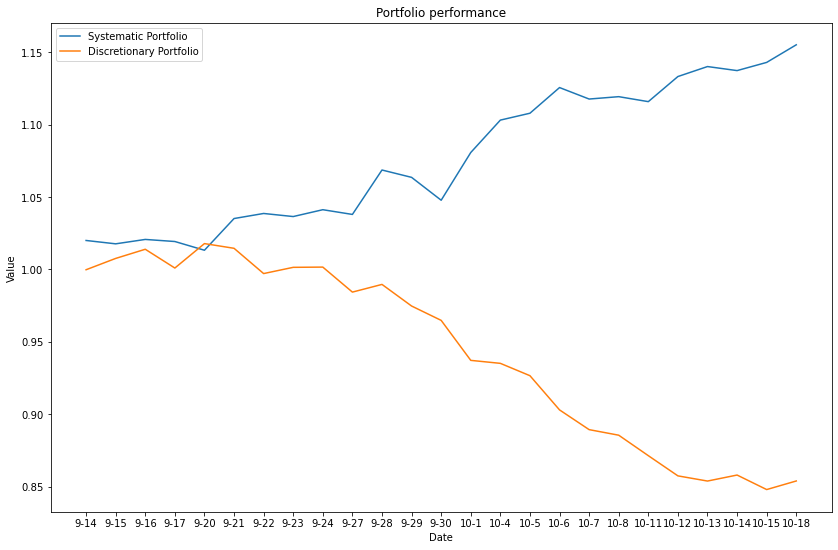

In [13]:
x = [s for s in range(len(pf_sys_pct))]
xticks = [str(d.month)+'-'+str(d.day) for d in pf_sys_pct.index]
plt.figure(figsize=(14,9))
plt.plot(x, np.cumprod(1+pf_sys_pct), label = "Systematic Portfolio")
plt.plot(x, pf_discret_value, label = "Discretionary Portfolio")
plt.xticks(x, xticks)
plt.xlabel('Date')
plt.ylabel("Value")
plt.title("Portfolio performance")
plt.legend()
plt.show()